<br>
<u>Notebook Seven</u> | 
<a href=https://leone.gdn/DLL target=_blank>Report</a> | 
<a href=https://github.com/andrealeone/DLL>Repository</a>
<br><br>
<b>Task 1: Ensemble of the attribute classifiers</b><br><br>
Andrea Leone, Alessandro E. Piotti<br>
Deep Learning Lab — University of Trento<br>
December 2021
<hr><br><br>

In [1]:
import project 
import networks

import os
import pickle
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import random
import collections

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchvision

import sklearn
import sklearn.neural_network

from tqdm.notebook   import tqdm

project.notebook()

In [2]:
images, annotations = project.load_resources() 

<hr><br><br>

## `Age` classifier

<br><br>Load the models

In [3]:
device     = torch.device('cpu') 
models     = list() 
models_src = [ 
    ( './models/age_3cnv_5fc_f0.v4.x10.net', project.CNN(6144) ),
    ( './models/age_3cnv_5fc_f1.v4.x10.net', project.CNN(6144) ),
    ( './models/age_3cnv_5fc_f2.v4.x10.net', project.CNN(6144) ),
    ( './models/age_3cnv_5fc_f3.v4.x10.net', project.CNN(6144) )
]

for weights_dir, model in models_src: 
    model.load_state_dict( torch.load(weights_dir, map_location=device) )
    models.append( model ) 

<br><br>Load the data

In [4]:
attribute  = 'age' 

split_val  = 640                # 751-640=151
dictionary = dict()
irm        = torchvision.io.ImageReadMode.RGB

for image_file in tqdm(images):
    
    image_id = int(image_file.split('/')[-1].split('_')[0])
    
    label    = annotations.loc[image_id][attribute] - 1
    tensor   = torchvision.io.read_image( image_file, irm ).float()

    channels, height, width = tensor.shape
    tensor    = tensor.reshape(1, channels, height, width)
    
    if image_id not in dictionary:
        dictionary[image_id] = list()
        dictionary[image_id].append([tensor, label])
    else:
        dictionary[image_id].append([tensor, label])
    
data = list(dictionary.items())
random.Random(3).shuffle(data)

train_set, test_set = project.split_dataset(data,split_val)

project.inspect_dataset(data,train_set,test_set)

train_targets       = [y for _,y in train_set] 
train_class_weights = torch.tensor(
    sklearn.utils.class_weight.compute_class_weight(
        y=train_targets, classes=np.unique(train_targets),
        class_weight='balanced'
    ), dtype=torch.float
) 

train_class_weights 

  0%|          | 0/12989 [00:00<?, ?it/s]

data:     Counter({1: 10660, 2: 2039, 3: 186, 0: 104})
train:    Counter({1: 9159, 2: 1798, 3: 125, 0: 88})
test:     Counter({1: 1501, 2: 241, 3: 61, 0: 16})


tensor([31.7330,  0.3049,  1.5531, 22.3400])

<br><br>Process sample from `train_set`

In [5]:
x, y = train_set[0] 

In [6]:
np.array([ model( x.float() ).tolist()[0] for model in models ]) 

array([[-0.07829417,  0.31066269],
       [-0.46796942,  0.50943929],
       [-0.01339693, -0.03324118],
       [-0.09660313, -0.45051453]])

<br><br>Combine the models and obtain the result embedding

In [7]:
v  = '2'                        # archive version 
s1 = 'ensembled.train.{}.v{}.pkl'.format(attribute, v) 

if s1 in os.listdir('./data/'): 

    with open('./data/' + s1, 'rb') as file: 
        s1 = list( pickle.load( file ) )

    Y = [ y for _,y in s1 ] 
    X = [ x for x,_ in s1 ] 

else:

    Y = [ y for _,y in train_set ] 
    X = [
        np.array([
            model( x.float() ).tolist()[0] for model in models
        ]).reshape(-1) for x,_ in tqdm( train_set )
    ]

    with open('./data/' + s1, 'wb') as file: 
        pickle.dump( zip(X,Y), file ) 

In [8]:
v  = '2'                        # archive version 
s2 = 'ensembled.test.{}.v{}.pkl'.format(attribute, v) 

if s2 in os.listdir('./data/'): 

    with open('./data/' + s2, 'rb') as file: 
        s2 = list( pickle.load( file ) )

    T = [ t for _,t in s2 ] 
    Z = [ z for z,_ in s2 ] 

else:

    T = [ t for _,t in test_set ] 
    Z = [
        np.array([
            model( z.float() ).tolist()[0] for model in models
        ]).reshape(-1) for z,_ in tqdm( test_set )
    ]

    with open('./data/' + s2, 'wb') as file: 
        pickle.dump( zip(Z,T), file ) 

<br><br>Scikit-Learn simple MLP classifier

In [9]:
mlp = sklearn.neural_network.MLPClassifier().fit(X,Y) 

In [10]:
z = mlp.predict(Z) 

In [11]:
project.prediction_accuracy(z, T) 

0.8042880703683343

<br><br>PyTorch custom CNN classifier

In [ ]:
s1 = list( zip( 
    [ torch.tensor(x)        for x in X ],
    [ torch.tensor(y).long() for y in Y ]
))

In [ ]:
s2 = list( zip( 
    [ torch.tensor(x)        for x in Z ],
    [ torch.tensor(y).long() for y in T ]
))

In [ ]:
class Network(nn.Module): 
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(  8, 32 )
        self.fc2 = nn.Linear( 32, 64 )
        self.fc3 = nn.Linear( 64, 32 )
        self.fc4 = nn.Linear( 32,  4 )
    
    def forward(self, x):
    
        x = x.unsqueeze(0)
        x = x.float()
        
        x = nn.functional.gelu( self.fc1(x) )
        x = nn.functional.gelu( self.fc2(x) )
        x = nn.functional.gelu( self.fc3(x) )
        x = nn.functional.gelu( self.fc4(x) )
        
        return x

In [ ]:
v = '1_2'                       # model version 
e =  0                          # starting epoch


model = Network()

if e > 0:
    w = './models/{}_ensemble.v{}.x{}.net'.format(attribute, v, e)
    model.load_state_dict( torch.load(w) )


optimizer = optim.Adagrad(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(1): 

    model_name = '{}_ensemble.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, s1,
        criterion, optimizer, epochs=1, li=2234, monobatch=False
    )

    r = project.test(model, s2, monobatch=False) 

    if (i+1) % 5 == 0:
        project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | accuracy           | precision | recall
#                    |        |                    |           |
# c.cnn w/Adagrad    |  1     | 0.8037383177570093 | 0.2933509 | 0.2887853
# c.cnn w/Adagrad    |  2     | 0.8070368334249588 | 0.2963891 | 0.2889139
# c.cnn w/Adagrad    |  3     | 0.8070368334249588 | 0.2946399 | 0.2871723
# c.cnn w/Adagrad    |  4     | 0.8059373282023090 | 0.2916899 | 0.2850976
# c.cnn w/Adagrad    |  5     | 0.8048378229796591 | 0.2898511 | 0.2838937
# c.cnn w/Adagrad    |  6     | 0.8042880703683343 | 0.2881619 | 0.2828564
# c.cnn w/Adagrad    |  7     | 0.8042880703683343 | 0.2881619 | 0.2828564
# c.cnn w/Adagrad    |  8     | 0.8048378229796591 | 0.2894567 | 0.2838937
# c.cnn w/Adagrad    |  9     | 0.8048378229796591 | 0.2894567 | 0.2838937
# c.cnn w/Adagrad    | 10     | 0.8053875755909841 | 0.2914549 | 0.2858019
#                    |        |                    |           |
# c.cnn w/Adagrad    | 11     | 0.8053875755909841 | 0.2914549 | 0.2858019
# c.cnn w/Adagrad    | 12     | 0.8059373282023090 | 0.2916048 | 0.2859684
# c.cnn w/Adagrad    | 13     | 0.8059373282023090 | 0.2916048 | 0.2859684
# c.cnn w/Adagrad    | 14     | 0.8064870808136338 | 0.2921501 | 0.2861350
# c.cnn w/Adagrad    | 15     | 0.8059373282023090 | 0.2908858 | 0.2850976
# c.cnn w/Adagrad    | 16     | 0.8059373282023090 | 0.2908858 | 0.2850976
# c.cnn w/Adagrad    | 17     | 0.8070368334249588 | 0.2931118 | 0.2863015
# c.cnn w/Adagrad    | 18     | 0.8064870808136338 | 0.2922525 | 0.2852642
# c.cnn w/Adagrad    | 19     | 0.8059373282023090 | 0.2916899 | 0.2850976
# c.cnn w/Adagrad    | 20     | 0.8053875755909841 | 0.2911345 | 0.2849311

<hr><br><br>

## `Colors_Up` classifier

<br><br>Load the models

In [12]:
device     = torch.device('cpu') 
models     = list() 
models_src = [ 
    ( './models/colors_up_resnet50_f0.v3_2.x22.net', networks.ResNet50() ),
    ( './models/colors_up_resnet50_f1.v3_2.x8.net',  networks.ResNet50() ),
    ( './models/colors_up_resnet50_f2.v3_2.x3.net',  networks.ResNet50() ),
    ( './models/colors_up_resnet50_f3.v3_2.x3.net',  networks.ResNet50() ),
    ( './models/colors_up_resnet50_f4.v3_2.x5.net',  networks.ResNet50() ),
    ( './models/colors_up_resnet50_f5.v3_2.x4.net',  networks.ResNet50() ),
    ( './models/colors_up_resnet50_f6.v3_2.x12.net', networks.ResNet50() ),
    ( './models/colors_up_resnet50_f7.v3_2.x8.net',  networks.ResNet50() ),
    ( './models/colors_up_resnet50_f8.v3_2.x4.net',  networks.ResNet50() )
]

for weights_dir, model in models_src: 
    model.load_state_dict( torch.load(weights_dir, map_location=device) )
    models.append( model ) 

<br><br>Load the data

  0%|          | 0/12989 [00:00<?, ?it/s]

data:     Counter({2: 3695, 1: 1774, 6: 1501, 3: 1408, 7: 1185, 0: 1133, 5: 983, 8: 883, 4: 427})
train:    Counter({2: 3143, 1: 1506, 3: 1285, 6: 1246, 7: 1097, 0: 998, 5: 819, 8: 664, 4: 412})
test:     Counter({2: 552, 1: 268, 6: 255, 8: 219, 5: 164, 0: 135, 3: 123, 7: 88, 4: 15})


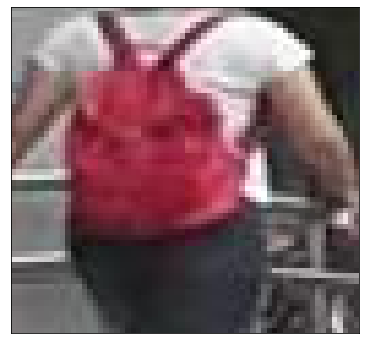

In [13]:
attribute  = 'colors_up' 

split_val  = 640                # 751-640=151
dictionary = dict()
irm        = torchvision.io.ImageReadMode.RGB
colors     = [
    'upblack', 'upwhite', 'upred', 'uppurple',
    'upyellow', 'upgray', 'upblue', 'upgreen'
]

for image_file in tqdm(images):
    
    image_id  = int(image_file.split('/')[-1].split('_')[0])
    array     = [(annotations.loc[image_id][color] - 1) for color in colors]
    tensor    = torchvision.io.read_image( image_file, irm ).float()
    
    if 1 in array:
        label = (array.index(1) + 1)
    else:
        label = 0
    
    ct = list()
    for c,channel in enumerate(tensor):
        ct.append( tensor[c][20:80].numpy() )
    
    tensor    = torch.tensor(ct).float()
    
    channels, height, width = tensor.shape
    tensor    = tensor.reshape(1, channels, height, width)
    
    if image_id not in dictionary:
        dictionary[image_id] = list()
        dictionary[image_id].append([tensor, label])
    else:
        dictionary[image_id].append([tensor, label])
    
data = list(dictionary.items())
random.Random(3).shuffle(data)

train_set, test_set = project.split_dataset(data, split_val)

project.inspect_dataset(data,train_set,test_set) 
project.plot_image(train_set[0][0].reshape([3, 60, 64]), fs=(16,6)) 

<br><br>Combine the models and obtain the result embedding

In [14]:
v  = '2'                        # archive version 
s1 = 'ensembled.train.{}.v{}.pkl'.format(attribute, v) 

if s1 in os.listdir('./data/'): 

    with open('./data/' + s1, 'rb') as file: 
        s1 = list( pickle.load( file ) )

    Y = [ y for _,y in s1 ] 
    X = [ x for x,_ in s1 ] 

else:

    Y = [ y for _,y in train_set ] 
    X = [
        np.array([
            model( x.float() ).tolist()[0] for model in models
        ]).reshape(-1) for x,_ in tqdm( train_set )
    ]

    with open('./data/' + s1, 'wb') as file: 
        pickle.dump( zip(X,Y), file ) 

In [15]:
v  = '2'                        # archive version 
s2 = 'ensembled.test.{}.v{}.pkl'.format(attribute, v) 

if s2 in os.listdir('./data/'): 

    with open('./data/' + s2, 'rb') as file: 
        s2 = list( pickle.load( file ) )

    T = [ t for _,t in s2 ] 
    Z = [ z for z,_ in s2 ] 

else:

    T = [ t for _,t in test_set ] 
    Z = [
        np.array([
            model( z.float() ).tolist()[0] for model in models
        ]).reshape(-1) for z,_ in tqdm( test_set )
    ]

    with open('./data/' + s2, 'wb') as file: 
        pickle.dump( zip(Z,T), file ) 

<br><br>Scikit-Learn simple MLP classifier

In [16]:
mlp = sklearn.neural_network.MLPClassifier().fit(X,Y) 

In [17]:
z = mlp.predict(Z) 

In [18]:
project.prediction_accuracy(z, T) 

0.6509070918086861

<br><br>PyTorch custom CNN classifier

In [ ]:
s1 = list( zip( 
    [ torch.tensor(x)        for x in X ],
    [ torch.tensor(y).long() for y in Y ]
))

In [ ]:
s2 = list( zip( 
    [ torch.tensor(x)        for x in Z ],
    [ torch.tensor(y).long() for y in T ]
))

In [ ]:
train_class_weights = torch.tensor( 
    sklearn.utils.class_weight.compute_class_weight(
        y=Y, classes=np.unique(Y), class_weight='balanced'
    ), dtype=torch.float
) 

train_class_weights 

In [ ]:
class Network(nn.Module): 
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear( 18, 72 )
        self.fc2 = nn.Linear( 72, 36 )
        self.fc3 = nn.Linear( 36,  9 )
    
    def forward(self, x):
    
        x = x.unsqueeze(0)
        x = x.float()
        
        x = nn.functional.gelu( self.fc1(x) )
        x = nn.functional.gelu( self.fc2(x) )
        x = nn.functional.gelu( self.fc3(x) )
        
        return x

In [ ]:
v = '1_2'                       # model version 
e =  0                          # starting epoch


model = Network()

if e > 0:
    w = './models/{}_ensemble.v{}.x{}.net'.format(attribute, v, e)
    model.load_state_dict( torch.load(w) )


optimizer = optim.Adagrad(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(1): 

    model_name = '{}_ensemble.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, s1,
        criterion, optimizer, epochs=1, li=2234, monobatch=False
    )

    r = project.test(model, s2, monobatch=False) 

    if (i+1) % 5 == 0:
        project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | accuracy           | precision | recall
#                    |        |                    |           |
# c.cnn w/Adagrad    |  1     | 0.6569543705332600 | 0.4948931 | 0.5492292
# c.cnn w/Adagrad    |  2     | 0.6712479384277076 | 0.5032331 | 0.5564977
# c.cnn w/Adagrad    |  3     | 0.6695986805937328 | 0.5000484 | 0.5532341
# c.cnn w/Adagrad    |  4     | 0.6739967014843321 | 0.5162510 | 0.5701317
# c.cnn w/Adagrad    |  5     | 0.6723474436503574 | 0.5136101 | 0.5670996
# c.cnn w/Adagrad    |  6     | 0.6734469488730072 | 0.5142811 | 0.5676467
# c.cnn w/Adagrad    |  7     | 0.6723474436503574 | 0.5131112 | 0.5663499
# c.cnn w/Adagrad    |  8     | 0.6750962067069819 | 0.5159815 | 0.5684374
# c.cnn w/Adagrad    |  9     | 0.6756459593183067 | 0.5165721 | 0.5688520
# c.cnn w/Adagrad    | 10     | 0.6761957119296317 | 0.5173036 | 0.5692877
#                    |        |                    |           |
# c.cnn w/Adagrad    | 11     | 0.6734469488730072 | 0.5202553 | 0.5736903
# c.cnn w/Adagrad    | 12     | 0.6745464540956569 | 0.5253676 | 0.5817468
# c.cnn w/Adagrad    | 13     | 0.6745464540956569 | 0.5257351 | 0.5820529
# c.cnn w/Adagrad    | 14     | 0.6750962067069819 | 0.5263613 | 0.5824170
# c.cnn w/Adagrad    | 15     | 0.6745464540956569 | 0.5271684 | 0.5822157
# c.cnn w/Adagrad    | 16     | 0.6761957119296317 | 0.5287802 | 0.5834806
# c.cnn w/Adagrad    | 17     | 0.6761957119296317 | 0.5264371 | 0.5829918
# c.cnn w/Adagrad    | 18     | 0.6767454645409565 | 0.5268501 | 0.5834276
# c.cnn w/Adagrad    | 19     | 0.6767454645409565 | 0.5267132 | 0.5826007
# c.cnn w/Adagrad    | 20     | 0.6767454645409565 | 0.5266958 | 0.5826007
#

<hr><br><br>

## `Colors_Down` classifier

<br><br>Load the models

In [19]:
device     = torch.device('cpu') 
models     = list() 
models_src = [ 
    ( './models/colors_down_resnet50_f0.v3_2.x5.net',  networks.ResNet50() ),
    ( './models/colors_down_resnet50_f1.v3_2.x6.net',  networks.ResNet50() ),
    ( './models/colors_down_resnet50_f2.v3_2.x9.net',  networks.ResNet50() ),
    ( './models/colors_down_resnet50_f3.v3_2.x15.net', networks.ResNet50() ),
    ( './models/colors_down_resnet50_f4.v3_2.x12.net', networks.ResNet50() ),
    ( './models/colors_down_resnet50_f5.v3_2.x11.net', networks.ResNet50() ),
    ( './models/colors_down_resnet50_f6.v3_2.x9.net',  networks.ResNet50() ),
    ( './models/colors_down_resnet50_f7.v3_2.x7.net',  networks.ResNet50() ),
    ( './models/colors_down_resnet50_f8.v3_2.x4.net',  networks.ResNet50() ),
    ( './models/colors_down_resnet50_f9.v3_2.x8.net',  networks.ResNet50() )
]

for weights_dir, model in models_src: 
    model.load_state_dict( torch.load(weights_dir, map_location=device) )
    models.append( model ) 

<br><br>Load the data

  0%|          | 0/12989 [00:00<?, ?it/s]

data:     Counter({1: 5083, 7: 2367, 6: 1999, 9: 1060, 2: 842, 0: 688, 3: 470, 8: 330, 5: 139, 4: 11})
train:    Counter({1: 4256, 7: 2091, 6: 1777, 9: 857, 2: 722, 0: 607, 3: 422, 8: 288, 5: 139, 4: 11})
test:     Counter({1: 827, 7: 276, 6: 222, 9: 203, 2: 120, 0: 81, 3: 48, 8: 42})


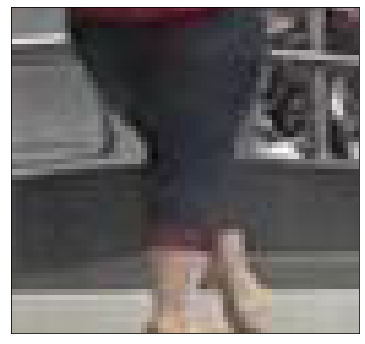

In [20]:
attribute  = 'colors_down' 

split_val  = 640                # 751-640=151
dictionary = dict()
irm        = torchvision.io.ImageReadMode.RGB
colors     = [
    'downblack', 'downwhite', 'downpink', 'downpurple', 'downyellow',
    'downgray', 'downblue', 'downgreen', 'downbrown'
]

for image_file in tqdm(images):
    
    image_id  = int(image_file.split('/')[-1].split('_')[0])
    array     = [(annotations.loc[image_id][color] - 1) for color in colors]
    tensor    = torchvision.io.read_image( image_file,irm ).float()
    
    if 1 in array:
        label = (array.index(1) + 1)
    else:
        label = 0
    
    ct = list()
    for c,channel in enumerate(tensor):
        ct.append( tensor[c][60:120].numpy() )
    
    tensor    = torch.tensor(ct).float()
    
    channels, height, width = tensor.shape
    tensor    = tensor.reshape(1, channels, height, width)
    
    if image_id not in dictionary:
        dictionary[image_id] = list()
        dictionary[image_id].append([tensor, label])
    else:
        dictionary[image_id].append([tensor, label])
    
data = list(dictionary.items())
random.Random(3).shuffle(data)

train_set, test_set = project.split_dataset(data, split_val)

project.inspect_dataset(data,train_set,test_set) 
project.plot_image(train_set[0][0].reshape([3, 60, 64]), fs=(16,6)) 

<br><br>Combine the models and obtain the result embedding

In [21]:
v  = '2'                        # archive version 
s1 = 'ensembled.train.{}.v{}.pkl'.format(attribute, v) 

if s1 in os.listdir('./data/'): 

    with open('./data/' + s1, 'rb') as file: 
        s1 = list( pickle.load( file ) )

    Y = [ y for _,y in s1 ] 
    X = [ x for x,_ in s1 ] 

else:

    Y = [ y for _,y in train_set ] 
    X = [
        np.array([
            model( x.float() ).tolist()[0] for model in models
        ]).reshape(-1) for x,_ in tqdm( train_set )
    ]

    with open('./data/' + s1, 'wb') as file: 
        pickle.dump( zip(X,Y), file ) 

In [22]:
v  = '2'                        # archive version 
s2 = 'ensembled.test.{}.v{}.pkl'.format(attribute, v) 

if s2 in os.listdir('./data/'): 

    with open('./data/' + s2, 'rb') as file: 
        s2 = list( pickle.load( file ) )

    T = [ t for _,t in s2 ] 
    Z = [ z for z,_ in s2 ] 

else:

    T = [ t for _,t in test_set ] 
    Z = [
        np.array([
            model( z.float() ).tolist()[0] for model in models
        ]).reshape(-1) for z,_ in tqdm( test_set )
    ]

    with open('./data/' + s2, 'wb') as file: 
        pickle.dump( zip(Z,T), file ) 

<br><br>Scikit-Learn simple MLP classifier

In [23]:
mlp = sklearn.neural_network.MLPClassifier().fit(X,Y) 

In [24]:
z = mlp.predict(Z) 

In [25]:
project.prediction_accuracy(z, T) 

0.5880263825469305

<br><br>PyTorch custom CNN classifier

In [ ]:
s1 = list( zip( 
    [ torch.tensor(x)        for x in X ],
    [ torch.tensor(y).long() for y in Y ]
))

In [ ]:
s2 = list( zip( 
    [ torch.tensor(z)        for z in Z ],
    [ torch.tensor(t).long() for t in T ]
))

In [ ]:
train_class_weights = torch.tensor( 
    sklearn.utils.class_weight.compute_class_weight(
        y=Y, classes=np.unique(Y), class_weight='balanced'
    ), dtype=torch.float
) 

train_class_weights 

In [ ]:
class Network(nn.Module): 
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear( 20, 80 )
        self.fc2 = nn.Linear( 80, 40 )
        self.fc3 = nn.Linear( 40, 10 )
    
    def forward(self, x):
    
        x = x.unsqueeze(0)
        x = x.float()
        
        x = nn.functional.gelu( self.fc1(x) )
        x = nn.functional.gelu( self.fc2(x) )
        x = nn.functional.gelu( self.fc3(x) )
        
        return x

In [ ]:
v = '1_2'                       # model version 
e =  0                          # starting epoch


model = Network()

if e > 0:
    w = './models/{}_ensemble.v{}.x{}.net'.format(attribute, v, e)
    model.load_state_dict( torch.load(w) )


optimizer = optim.Adagrad(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(1): 

    model_name = '{}_ensemble.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, s1,
        criterion, optimizer, epochs=1, li=2234, monobatch=False
    )

    r = project.test(model, s2, monobatch=False) 

    if (i+1) % 5 == 0:
        project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | accuracy           | precision | recall
#                    |        |                    |           |
# c.cnn w/Adagrad    |  1     | 0.5717909690512430 | 0.2986831 | 0.3809349
# c.cnn w/Adagrad    |  2     | 0.5778792491121258 | 0.3044822 | 0.4125680
# c.cnn w/Adagrad    |  3     | 0.5834601725012684 | 0.3073872 | 0.4149471
# c.cnn w/Adagrad    |  4     | 0.5865043125317098 | 0.3099118 | 0.4158917
# c.cnn w/Adagrad    |  5     | 0.5900558092338914 | 0.3127141 | 0.4203315
# c.cnn w/Adagrad    |  6     | 0.5915778792491121 | 0.3132961 | 0.4213663
# c.cnn w/Adagrad    |  7     | 0.5930999492643328 | 0.3149152 | 0.4228751
# c.cnn w/Adagrad    |  8     | 0.5930999492643328 | 0.3150858 | 0.4229994
# c.cnn w/Adagrad    |  9     | 0.5915778792491121 | 0.3145255 | 0.4224248
# c.cnn w/Adagrad    | 10     | 0.5920852359208524 | 0.3149563 | 0.4227054
#                    |        |                    |           |
# c.cnn w/Adagrad    | 15     | 0.5915778792491121 | 0.3141158 | 0.4223724
# c.cnn w/Adagrad    | 20     | 0.5925925925925926 | 0.3134097 | 0.4175161
# c.cnn w/Adagrad    | 25     | 0.5956367326230340 | 0.3161548 | 0.4214133
# c.cnn w/Adagrad    | 30     | 0.5961440892947742 | 0.3160007 | 0.4209002
#

<br><br>